In [ ]:
!pip -q install huggingface_hub plyfile
from huggingface_hub import list_repo_files, hf_hub_download
REPO_ID = "pjramg/gaussian_splatting"
files = list_repo_files(REPO_ID, repo_type="dataset")
print("Found", len(files), "files. Showing a few:")
for f in files[:40]:
    print(" ", f)
candidates = [f for f in files if "playroom" in f.lower() and f.lower().endswith(".ply")]
print("\nPLY candidates for playroom:", candidates)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 1.7 MB/s eta 0:00:00
Found 18 files. Showing a few:
  .gitattributes
  FO_dataset/drjohnson/IMG_6292.jpg
  FO_dataset/drjohnson/IMG_6293.jpg
  FO_dataset/drjohnson/point_cloud/iteration_30000/point_cloud.ply
  FO_dataset/drjohnson/point_cloud/iteration_7000/point_cloud.ply
  FO_dataset/playroom/DSC05572.jpg
  FO_dataset/playroom/DSC05573.jpg
  FO_dataset/playroom/point_cloud/iteration_30000/point_cloud.ply
  FO_dataset/playroom/point_cloud/iteration_7000/point_cloud.ply
  FO_dataset/train/00001.jpg
  FO_dataset/train/00002.jpg
  FO_dataset/train/point_cloud/iteration_30000/point_cloud.ply
  FO_dataset/train/point_cloud/iteration_7000/point_cloud.ply
  FO_dataset/truck/000001.jpg
  FO_dataset/truck/000002.jpg
  FO_dataset/truck/point_cloud/iteration_30000/point_cloud.ply
  FO_dataset/truck/point_cloud/iteration_7000/point_cloud.ply
  README.md

PLY candidates for playroom: ['FO_dataset/playroom/point_cloud/iteration_30000/point_

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import os
REPO_ID = "pjramg/gaussian_splatting"
REMOTE_PLY = "FO_dataset/playroom/point_cloud/iteration_30000/point_cloud.ply"
local_ply_path = hf_hub_download(
    repo_id=REPO_ID,
    repo_type="dataset",
    filename=REMOTE_PLY,
    local_dir="/content",
)
print("Downloaded to:", local_ply_path, "exists:", os.path.exists(local_ply_path))

FO_dataset/playroom/point_cloud/iteratio(…):   0%|          | 0.00/475M [00:00<?, ?B/s]

Downloaded to: /content/FO_dataset/playroom/point_cloud/iteration_30000/point_cloud.ply exists: True


In [ ]:
from plyfile import PlyData
import torch
ply = PlyData.read(local_ply_path)
v = ply['vertex'].data
print("Vertex fields:", v.dtype.names[:15], "... total:", len(v.dtype.names))

first = v[0]
print("\nSample vertex:")
for name in v.dtype.names[:20]:
    print(f"  {name}: {first[name]}")

Vertex fields: ('x', 'y', 'z', 'nx', 'ny', 'nz', 'f_dc_0', 'f_dc_1', 'f_dc_2', 'f_rest_0', 'f_rest_1', 'f_rest_2', 'f_rest_3', 'f_rest_4', 'f_rest_5') ... total: 62

Sample vertex:
  x: -5.751795768737793
  y: 4.783945560455322
  z: -0.5513789057731628
  nx: 0.0
  ny: 0.0
  nz: 0.0
  f_dc_0: 0.11399218440055847
  f_dc_1: -0.6850193738937378
  f_dc_2: -1.7829861640930176
  f_rest_0: -0.013615659438073635
  f_rest_1: 0.04139026254415512
  f_rest_2: -0.015623421408236027
  f_rest_3: 0.01787213422358036
  f_rest_4: -0.03703312948346138
  f_rest_5: 0.03613635525107384
  f_rest_6: 0.01284429244697094
  f_rest_7: -0.036501336842775345
  f_rest_8: 0.04531172662973404
  f_rest_9: -0.013570110313594341
  f_rest_10: -0.020238623023033142


In [ ]:
!pip -q install gsplat plyfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 16.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ply = PlyData.read("/content/FO_dataset/playroom/point_cloud/iteration_30000/point_cloud.ply")
v = ply['vertex'].data
names = v.dtype.names
def stack(names_list):
    return torch.from_numpy(np.stack([v[n] for n in names_list], 1).astype(np.float32)).to(device)

means = stack(['x','y','z'])
scales = torch.full_like(means, 0.01);
if all(n in names for n in ('scale_0','scale_1','scale_2')):
    scales = torch.exp(stack(['scale_0','scale_1','scale_2']))
quats = None
if all(n in names for n in ('rot_0','rot_1','rot_2','rot_3')):
    quats = stack(['rot_0','rot_1','rot_2','rot_3'])

opacity = torch.full((means.shape[0],1), 0.7, device=device)
if 'opacity' in names:
    opacity = torch.sigmoid(torch.from_numpy(np.array(v['opacity'], np.float32)).to(device)).unsqueeze(1)


dc = stack(['f_dc_0','f_dc_1','f_dc_2']).unsqueeze(1)
dc = torch.sigmoid(dc)
rest_count = len([n for n in names if n.startswith('f_rest_')])
features_rest = torch.zeros((means.shape[0], max(0, rest_count//3), 3), device=device)
if rest_count >= 45:
    f_rest = stack([f"f_rest_{i}" for i in range(rest_count)])
    K = rest_count // 3
    f_rest = f_rest.view(means.shape[0], 3, K).permute(0,2,1).contiguous()
    features_rest = f_rest

print("means", means.shape, "scales", scales.shape, "opacity", opacity.shape, "dc", dc.shape, "rest", features_rest.shape)

means torch.Size([1916379, 3]) scales torch.Size([1916379, 3]) opacity torch.Size([1916379, 1]) dc torch.Size([1916379, 1, 3]) rest torch.Size([1916379, 15, 3])


/tmp/ipython-input-1152319594.py:55: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:63.)
  x = torch.cross(z, up); x = x / torch.norm(x)       # use torch.linalg.cross in future


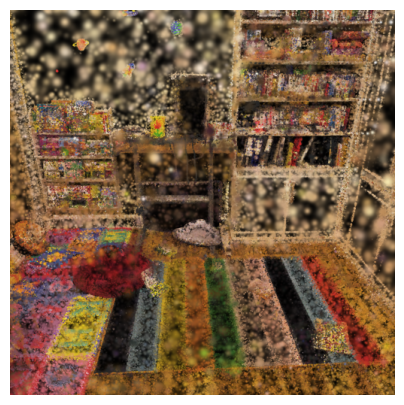

In [ ]:
import math
import matplotlib.pyplot as plt
local_ply_path = "/content/FO_dataset/playroom/point_cloud/iteration_30000/point_cloud.ply"
assert os.path.exists(local_ply_path), f"PLY not found at {local_ply_path}"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
H, W = 512, 512
ply = PlyData.read(local_ply_path)
v = ply['vertex'].data
names = v.dtype.names

def np_to_torch(cols):
    return torch.from_numpy(np.stack([v[c] for c in cols], axis=1).astype(np.float32)).to(device)

pos = np_to_torch(['x','y','z'])
f_dc = np_to_torch(['f_dc_0','f_dc_1','f_dc_2'])
colors = torch.sigmoid(f_dc)
if 'opacity' in names:
    opacity_logit = torch.from_numpy(np.array(v['opacity'], np.float32)).to(device)
    alpha = torch.sigmoid(opacity_logit)
else:
    alpha = torch.full((pos.shape[0],), 0.6, device=device)
if all(n in names for n in ('scale_0','scale_1','scale_2')):
    scales_log = np_to_torch(['scale_0','scale_1','scale_2'])
    scales = torch.exp(scales_log)
else:
    scales = torch.full((pos.shape[0],3), 0.01, device=device)

def pinhole_intrinsics(fov_deg, W, H, device):
    f = 0.5 * W / math.tan(0.5 * math.radians(fov_deg))
    K = torch.tensor([[f, 0, W/2],
                      [0, f, H/2],
                      [0, 0,   1 ]], dtype=torch.float32, device=device)
    return K, f

def look_at(eye, center, up=(0.,1.,0.)):
    eye, center, up = [torch.tensor(x, dtype=torch.float32, device=device) for x in (eye, center, up)]
    z = (center - eye); z = z / torch.norm(z)
    x = torch.cross(z, up); x = x / torch.norm(x)
    y = torch.cross(x, z)
    R = torch.stack([x,y,z], dim=0)
    t = -R @ eye
    return R,t

def project_points(pts, K, R, t):
    Xc = (R @ pts.T + t[:,None]).T
    z = Xc[:,2].clamp_min(1e-6)
    Xn = Xc / z[:,None]
    uv = (K @ Xn.T).T[:,:2]
    return uv, z

def radius_pixels_from_depth(size3d, z, focal_px, min_r=1.5, max_r=12.0):
    r = size3d * (focal_px / z.clamp_min(1e-3))
    return torch.clamp(r, min=min_r, max=max_r)


def render_gaussians_isotropic(uv, z, colors, alpha, radius_px, H, W):
    order = torch.argsort(z, descending=True)
    uv, z, colors, alpha, radius_px = [t[order] for t in (uv, z, colors, alpha, radius_px)]
    img = torch.zeros(H, W, 3, device=uv.device)
    acc = torch.zeros(H, W, device=uv.device)
    sigma = radius_px / 2.5
    for i in range(uv.shape[0]):
        u, v = uv[i]
        if not (-50 <= u <= W+50 and -50 <= v <= H+50):
            continue
        s = float(sigma[i].clamp_min(0.5))
        r = int(3*s)
        if r <= 0:
            continue
        u0, v0 = int(round(float(u))), int(round(float(v)))
        x0, x1 = max(0, u0 - r), min(W - 1, u0 + r)
        y0, y1 = max(0, v0 - r), min(H - 1, v0 + r)
        if x1 <= x0 or y1 <= y0:
            continue
        xs = torch.arange(x0, x1+1, device=uv.device)
        ys = torch.arange(y0, y1+1, device=uv.device)
        X, Y = torch.meshgrid(xs, ys, indexing='xy')
        w = torch.exp(-0.5 * (((X - u)**2 + (Y - v)**2) / (s*s)))
        a = alpha[i] * w
        region = img[y0:y1+1, x0:x1+1]
        region_acc = acc[y0:y1+1, x0:x1+1]
        contrib = (1.0 - region_acc).unsqueeze(-1) * a.unsqueeze(-1) * colors[i]
        img[y0:y1+1, x0:x1+1] = region + contrib
        acc[y0:y1+1, x0:x1+1] = region_acc + (1.0 - region_acc) * a
    return torch.clamp(img, 0.0, 1.0)

K, f = pinhole_intrinsics(60, W, H, device)
scene_center = pos.mean(0).tolist()
eye = [scene_center[0], scene_center[1], scene_center[2] - 6.5]
R, t = look_at(eye, scene_center)

uv, z = project_points(pos, K, R, t)
size3d = scales.mean(dim=1)
radius_px = radius_pixels_from_depth(size3d, z, f, min_r=1.5, max_r=12.0)
img = render_gaussians_isotropic(uv, z, colors, alpha, radius_px, H, W)

plt.figure(figsize=(5,5))
plt.imshow(img.detach().cpu().numpy())
plt.axis('off')
plt.show()

Saved 8 views to: /content/semgs_playroom/views
Example files: ['/content/semgs_playroom/views/playroom_view_00.png', '/content/semgs_playroom/views/playroom_view_01.png', '/content/semgs_playroom/views/playroom_view_02.png'] ...
Camera metadata: /content/semgs_playroom/views/cameras.json


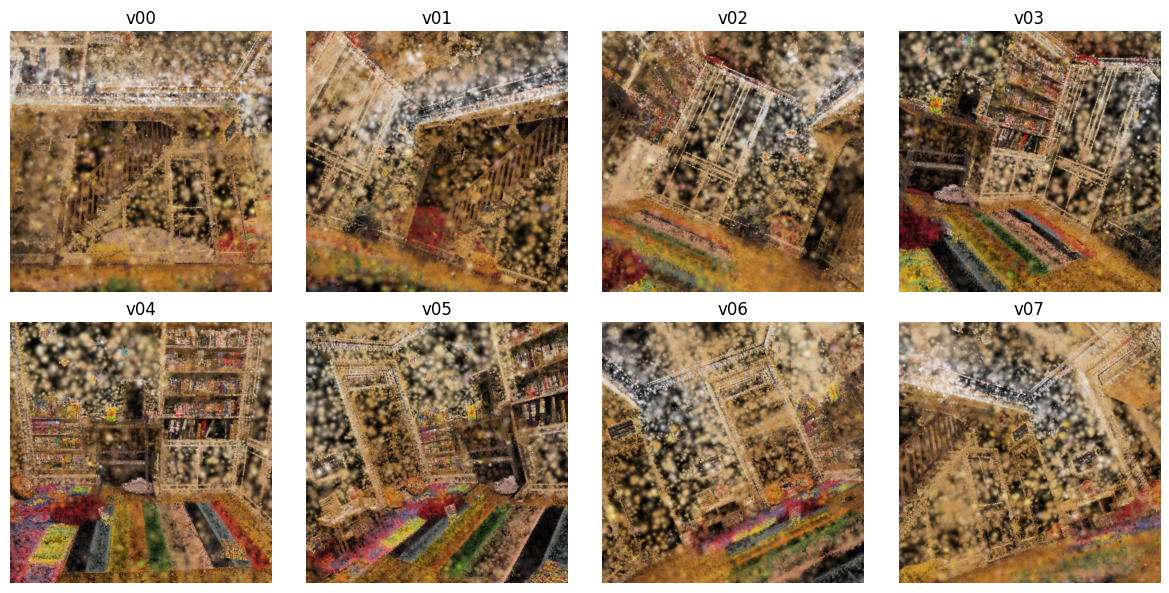

In [ ]:
import json
import imageio.v2 as imageio
assert 'pos' in globals() and 'scales' in globals(), "Run the previous Playroom loader cell first."

OUT_DIR = "/content/semgs_playroom/views"
os.makedirs(OUT_DIR, exist_ok=True)
H, W = 512, 512
FOV = 60
K, f = pinhole_intrinsics(FOV, W, H, pos.device)
n_views = 8
scene_center = pos.mean(0).tolist()
extent = float((pos - pos.mean(0)).norm(dim=1).quantile(0.9).cpu().item())
radius = max(6.5, extent * 0.7)

views = []
paths = []

size3d = scales.mean(dim=1)

for k in range(n_views):
    theta = 2 * math.pi * k / n_views
    eye = [
        scene_center[0] + radius * math.sin(theta),
        scene_center[1] + 0.15 * radius * math.sin(theta * 0.5),
        scene_center[2] + radius * math.cos(theta)
    ]
    R, t = look_at(eye, scene_center)
    uv, z = project_points(pos, K, R, t)
    radius_px = radius_pixels_from_depth(size3d, z, f, min_r=1.5, max_r=12.0)
    img = render_gaussians_isotropic(uv, z, colors, alpha, radius_px, H, W).detach().cpu().numpy()
    fn = os.path.join(OUT_DIR, f"playroom_view_{k:02d}.png")
    imageio.imwrite(fn, (img*255).astype(np.uint8))
    paths.append(fn)
    views.append({
        "R": R.detach().cpu().numpy().tolist(),
        "t": t.detach().cpu().numpy().tolist(),
        "K": K.detach().cpu().numpy().tolist(),
        "fov_deg": FOV,
        "H": H, "W": W
    })
META_PATH = os.path.join(OUT_DIR, "cameras.json")
with open(META_PATH, "w") as fmeta:
    json.dump({"views": views}, fmeta, indent=2)

print(f"Saved {len(paths)} views to: {OUT_DIR}")
print("Example files:", paths[:3], "...")
print("Camera metadata:", META_PATH)
cols = 4
rows = (n_views + cols - 1) // cols
plt.figure(figsize=(cols*3, rows*3))
for i, p in enumerate(paths):
    ax = plt.subplot(rows, cols, i+1)
    ax.imshow(imageio.imread(p))
    ax.set_title(f"v{i:02d}")
    ax.axis('off')
plt.tight_layout(); plt.show()

  Preparing metadata (setup.py) ... done
Got 46 masks


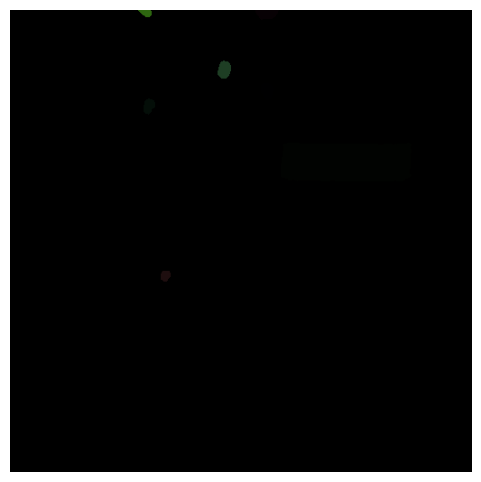

In [ ]:
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!pip -q install opencv-python matplotlib

import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_b_01ec64.pth"
sam_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
import os, urllib.request
if not os.path.exists(sam_checkpoint):
    urllib.request.urlretrieve(sam_url, sam_checkpoint)

device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(sam)
img_path = "/content/semgs_playroom/views/playroom_view_04.png"
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
print("Got", len(masks), "masks")

plt.figure(figsize=(6,6))
plt.imshow(image)
for m in masks:
    c = np.random.rand(3,)
    mask = m['segmentation']
    plt.imshow(np.dstack([mask* c[0], mask* c[1], mask* c[2]]), alpha=0.5)
plt.axis('off')
plt.show()

Kept 3 / 46 masks (min_area=5000, top_n=8)


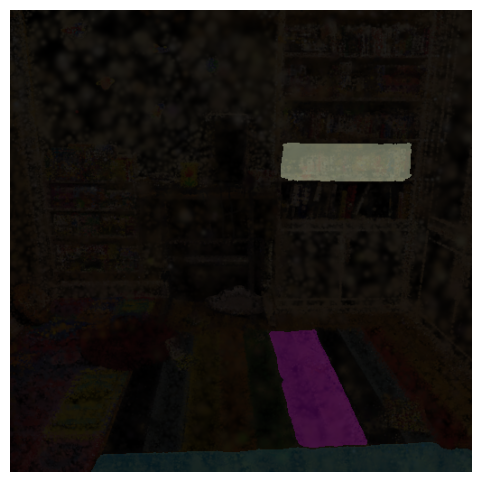

In [ ]:
def show_filtered_masks(image, masks, min_area=5000, top_n=10):
    masks = sorted(masks, key=lambda m: m['area'], reverse=True)
    filtered = [m for m in masks if m['area'] > min_area][:top_n]
    print(f"Kept {len(filtered)} / {len(masks)} masks (min_area={min_area}, top_n={top_n})")

    plt.figure(figsize=(6,6))
    plt.imshow(image)
    for m in filtered:
        c = np.random.rand(3,)
        mask = m['segmentation']
        plt.imshow(np.dstack([mask*c[0], mask*c[1], mask*c[2]]), alpha=0.5)
    plt.axis('off')
    plt.show()
    return filtered
filtered_masks = show_filtered_masks(image, masks, min_area=5000, top_n=8)

In [ ]:
from PIL import Image
with open("/content/semgs_playroom/views/cameras.json", "r") as f:
    meta = json.load(f)
views = meta["views"]

def project_to_view(pos, K, R, t, H, W):
    Xc = (R @ pos.T + t[:,None]).T
    z = Xc[:,2].clamp_min(1e-6)
    uv = (K @ (Xc / z[:,None]).T).T[:,:2]
    uv = uv.round().long()
    valid = (uv[:,0]>=0)&(uv[:,0]<W)&(uv[:,1]>=0)&(uv[:,1]<H)
    return uv, valid

MASK_DIR = "/content/semgs_playroom/masks"

n_splats = pos.shape[0]
votes = np.zeros((n_splats, 10), dtype=np.int32)

for vi, view in enumerate(views):
    for class_id in range(3):
        mask_path = f"{MASK_DIR}/view{vi:02d}_class{class_id}.png"
        if not os.path.exists(mask_path): continue
        mask = np.array(Image.open(mask_path).convert("L")) > 127
        K = torch.tensor(view["K"], dtype=torch.float32, device=pos.device)
        R = torch.tensor(view["R"], dtype=torch.float32, device=pos.device)
        t = torch.tensor(view["t"], dtype=torch.float32, device=pos.device)
        H, W = view["H"], view["W"]
        uv, valid = project_to_view(pos, K, R, t, H, W)
        uv = uv[valid].cpu().numpy()
        ids = np.where(valid.cpu().numpy())[0]
        inside = mask[uv[:,1], uv[:,0]]
        votes[ids, class_id] += inside.astype(int)
labels = votes.argmax(1)
print("Semantic labels assigned to splats:", np.bincount(labels))

Semantic labels assigned to splats: [1916379]


In [ ]:
VIEWS_DIR = "/content/semgs_playroom/views"
META_PATH = os.path.join(VIEWS_DIR, "cameras.json")
with open(META_PATH, "r") as f:
    meta = json.load(f)
n_views = len(meta["views"])
sam_checkpoint = "sam_vit_b_01ec64.pth"
if not os.path.exists(sam_checkpoint):
    import urllib.request
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        sam_checkpoint
    )
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint).to(device)
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=2000,
)

LABEL_DIR = "/content/semgs_playroom/labels"
os.makedirs(LABEL_DIR, exist_ok=True)

def compose_label_map(image_rgb, masks, min_area=8000, top_n=10):
    masks = sorted(masks, key=lambda m: m['area'], reverse=True)
    keep = [m for m in masks if m['area'] >= min_area][:top_n]
    H, W, _ = image_rgb.shape
    label_map = np.zeros((H, W), dtype=np.uint8)
    class_id = 1
    for m in keep:
        seg = m['segmentation'].astype(bool)
        label_map[(seg) & (label_map == 0)] = class_id
        class_id += 1
    return label_map, (class_id - 1)

all_classes = []
for vi in range(n_views):
    img_path = os.path.join(VIEWS_DIR, f"playroom_view_{vi:02d}.png")
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)
    label_map, K = compose_label_map(img, masks, min_area=8000, top_n=8)
    out_path = os.path.join(LABEL_DIR, f"labels_{vi:02d}.png")
    Image.fromarray(label_map).save(out_path)
    all_classes.append(K)
    print(f"view {vi:02d}: kept {K} classes -> {out_path}")

print("Max classes in any view:", max(all_classes))

view 00: kept 1 classes -> /content/semgs_playroom/labels/labels_00.png
view 01: kept 2 classes -> /content/semgs_playroom/labels/labels_01.png
view 02: kept 1 classes -> /content/semgs_playroom/labels/labels_02.png
view 03: kept 4 classes -> /content/semgs_playroom/labels/labels_03.png
view 04: kept 3 classes -> /content/semgs_playroom/labels/labels_04.png
view 05: kept 0 classes -> /content/semgs_playroom/labels/labels_05.png
view 06: kept 2 classes -> /content/semgs_playroom/labels/labels_06.png
view 07: kept 1 classes -> /content/semgs_playroom/labels/labels_07.png
Max classes in any view: 4


In [ ]:
with open(META_PATH, "r") as f:
    meta = json.load(f)
views = meta["views"]
H, W = views[0]["H"], views[0]["W"]

def project_to_view(pts, K, R, t, H, W, device):
    Xc = (R @ pts.T + t[:,None]).T
    z = Xc[:,2].clamp_min(1e-6)
    uv = (K @ (Xc / z[:,None]).T).T[:,:2]
    uv_ij = uv.round().long()
    valid = (uv_ij[:,0] >= 0) & (uv_ij[:,0] < W) & (uv_ij[:,1] >= 0) & (uv_ij[:,1] < H) & (z > 0)
    return uv_ij, valid

max_classes = 16
votes = torch.zeros((pos.shape[0], max_classes), dtype=torch.int32, device=pos.device)
for vi, view in enumerate(views):
    label_path = os.path.join(LABEL_DIR, f"labels_{vi:02d}.png")
    if not os.path.exists(label_path):
        continue
    label_img = torch.from_numpy(np.array(Image.open(label_path), dtype=np.uint8)).to(pos.device)
    K = torch.tensor(view["K"], dtype=torch.float32, device=pos.device)
    R = torch.tensor(view["R"], dtype=torch.float32, device=pos.device)
    t = torch.tensor(view["t"], dtype=torch.float32, device=pos.device)
    uv, valid = project_to_view(pos, K, R, t, H, W, pos.device)
    ids = torch.nonzero(valid, as_tuple=False).squeeze(1)
    uvv = uv[valid]
    cls = label_img[uvv[:,1], uvv[:,0]].long()
    cls = torch.clamp(cls, 0, max_classes-1)
    votes[ids, cls] += 1
labels = votes.argmax(dim=1)
counts = torch.bincount(labels, minlength=max_classes).cpu().numpy()
print("Label histogram:", counts.tolist())

Label histogram: [1737210, 178968, 0, 0, 201, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


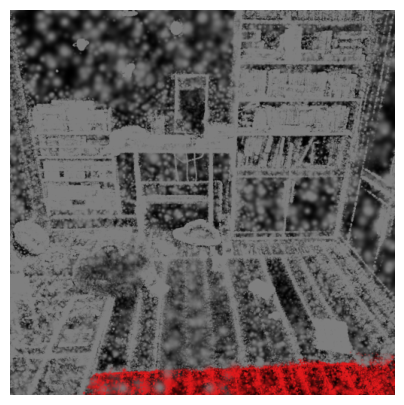

In [ ]:
palette = torch.tensor([
    [0.5, 0.5, 0.5],
    [0.89, 0.10, 0.11],
    [0.12, 0.47, 0.71],
    [0.17, 0.63, 0.17],
    [1.00, 0.50, 0.00],
    [0.58, 0.40, 0.74],
    [0.65, 0.81, 0.89],
    [0.70, 0.70, 0.70],
    [0.99, 0.75, 0.44],
    [0.74, 0.74, 0.13],
    [0.09, 0.75, 0.81],
    [0.95, 0.60, 0.60],
    [0.40, 0.76, 0.65],
    [0.65, 0.81, 0.89],
    [0.90, 0.67, 0.44],
    [0.99, 0.55, 0.38],
], device=pos.device)
label_clamped = torch.clamp(labels, 0, palette.shape[0]-1)
sem_colors = palette[label_clamped]
K, f = pinhole_intrinsics(60, W, H, pos.device)
scene_center = pos.mean(0).tolist()
eye = [scene_center[0], scene_center[1], scene_center[2] - 6.5]
R, t = look_at(eye, scene_center)
uv, z = project_points(pos, K, R, t)
size3d = scales.mean(dim=1)
radius_px = radius_pixels_from_depth(size3d, z, f, min_r=1.5, max_r=12.0)
img_sem = render_gaussians_isotropic(uv, z, sem_colors, alpha, radius_px, H, W)
plt.figure(figsize=(5,5)); plt.imshow(img_sem.detach().cpu().numpy()); plt.axis('off'); plt.show()

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.88,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1000,
)
label_map, K = compose_label_map(img, masks, min_area=1500, top_n=15)

In [ ]:
VIEWS_DIR = "/content/semgs_playroom/views"
LABEL_DIR = "/content/semgs_playroom/labels"
PREVIEW_DIR = "/content/semgs_playroom/labels_previews"
os.makedirs(LABEL_DIR, exist_ok=True)
os.makedirs(PREVIEW_DIR, exist_ok=True)

with open(os.path.join(VIEWS_DIR, "cameras.json"), "r") as f:
    meta = json.load(f)
n_views = len(meta["views"])

sam_checkpoint = "sam_vit_b_01ec64.pth"
if not os.path.exists(sam_checkpoint):
    import urllib.request
    urllib.request.urlretrieve(
        "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth",
        sam_checkpoint
    )
device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint).to(device)

mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side=32,
    pred_iou_thresh=0.80,
    stability_score_thresh=0.88,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=1000,
)

def shape_score(seg):
    seg_u8 = seg.astype(np.uint8)
    area = int(seg_u8.sum())
    if area == 0:
        return 0.0
    ys, xs = np.where(seg_u8)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()
    bw = max(1, x1 - x0 + 1)
    bh = max(1, y1 - y0 + 1)
    bbox_area = bw * bh
    fill_ratio = area / bbox_area
    aspect = max(bw, bh) / max(1.0, min(bw, bh))
    score = area * (0.5 + 0.5 * np.clip(fill_ratio, 0, 1)) * (1.0 if aspect <= 6 else 0.6)
    return float(score)

def compose_label_map(image_rgb, masks, min_area_px=1500, top_n=15):
    scored = []
    for m in masks:
        seg = m['segmentation']
        area = int(m['area'])
        if area < min_area_px:
            continue
        scored.append((shape_score(seg), m))
    scored.sort(key=lambda t: t[0], reverse=True)
    keep = [m for _, m in scored[:top_n]]

    H, W, _ = image_rgb.shape
    label_map = np.zeros((H, W), dtype=np.uint8)
    class_id = 1
    for m in keep:
        seg = m['segmentation'].astype(bool)
        label_map[(seg) & (label_map == 0)] = class_id
        class_id += 1
    return label_map, (class_id - 1), keep

kept_counts = []
for vi in range(n_views):
    img_path = os.path.join(VIEWS_DIR, f"playroom_view_{vi:02d}.png")
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    masks = mask_generator.generate(img)

    label_map, K, kept = compose_label_map(img, masks, min_area_px=1500, top_n=15)
    out_path = os.path.join(LABEL_DIR, f"labels_{vi:02d}.png")
    Image.fromarray(label_map).save(out_path)
    kept_counts.append(K)
    print(f"view {vi:02d}: kept {K} classes -> {out_path}")

    overlay = img.copy().astype(np.float32) / 255.0
    rng = np.random.default_rng(vi)
    for cid in range(1, K+1):
        color = rng.random(3)
        mask = (label_map == cid)
        overlay[mask] = 0.6 * overlay[mask] + 0.4 * color
    prev_path = os.path.join(PREVIEW_DIR, f"labels_preview_{vi:02d}.png")
    Image.fromarray((overlay*255).astype(np.uint8)).save(prev_path)

print("Max classes in any view:", max(kept_counts))
print("Preview PNGs in:", PREVIEW_DIR)

view 00: kept 15 classes -> /content/semgs_playroom/labels/labels_00.png
view 01: kept 10 classes -> /content/semgs_playroom/labels/labels_01.png
view 02: kept 9 classes -> /content/semgs_playroom/labels/labels_02.png
view 03: kept 15 classes -> /content/semgs_playroom/labels/labels_03.png
view 04: kept 15 classes -> /content/semgs_playroom/labels/labels_04.png
view 05: kept 15 classes -> /content/semgs_playroom/labels/labels_05.png
view 06: kept 12 classes -> /content/semgs_playroom/labels/labels_06.png
view 07: kept 10 classes -> /content/semgs_playroom/labels/labels_07.png
Max classes in any view: 15
Preview PNGs in: /content/semgs_playroom/labels_previews


In [ ]:
with open(META_PATH, "r") as f:
    meta = json.load(f)
views = meta["views"]
H, W = views[0]["H"], views[0]["W"]

def project_to_view(pts, K, R, t, H, W, device):
    Xc = (R @ pts.T + t[:,None]).T
    z = Xc[:,2].clamp_min(1e-6)
    uv = (K @ (Xc / z[:,None]).T).T[:,:2]
    uv_ij = uv.round().long()
    valid = (uv_ij[:,0] >= 0) & (uv_ij[:,0] < W) & (uv_ij[:,1] >= 0) & (uv_ij[:,1] < H) & (z > 0)
    return uv_ij, valid

max_classes = 16
votes = torch.zeros((pos.shape[0], max_classes), dtype=torch.int32, device=pos.device)

for vi, view in enumerate(views):
    label_path = os.path.join(LABEL_DIR, f"labels_{vi:02d}.png")
    if not os.path.exists(label_path):
        continue
    label_img = torch.from_numpy(np.array(Image.open(label_path), dtype=np.uint8)).to(pos.device)

    K = torch.tensor(view["K"], dtype=torch.float32, device=pos.device)
    R = torch.tensor(view["R"], dtype=torch.float32, device=pos.device)
    t = torch.tensor(view["t"], dtype=torch.float32, device=pos.device)

    uv, valid = project_to_view(pos, K, R, t, H, W, pos.device)
    ids = torch.nonzero(valid, as_tuple=False).squeeze(1)
    uvv = uv[valid]
    cls = label_img[uvv[:,1], uvv[:,0]].long()
    cls = torch.clamp(cls, 0, max_classes-1)
    votes[ids, cls] += 1

labels = votes.argmax(dim=1)  # 0..max_classes-1
counts = torch.bincount(labels, minlength=max_classes).cpu().numpy()
print("Label histogram:", counts.tolist())

Label histogram: [1715264, 175717, 10506, 2370, 4600, 1, 1, 7888, 6, 20, 1, 4, 1, 0, 0, 0]


Top classes (non-bg): [1 2 7 4 3] with counts: [175717  10506   7888   4600   2370]


Remapping top-K classes: 100%|██████████| 5/5 [00:00<00:00, 8243.52it/s]

Rendering reference view...


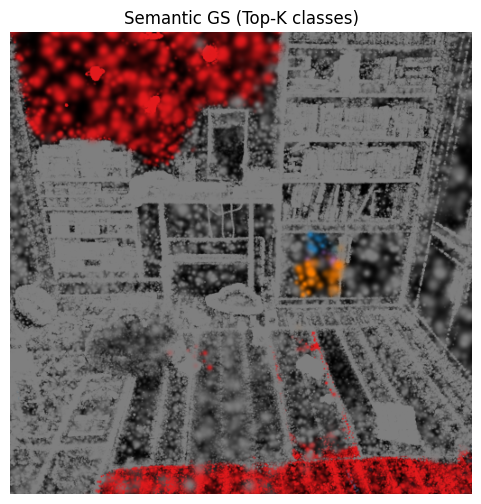

Saved: /content/semgs_playroom/outputs/semantic_topk.png

Legend:
  0 = background (gray)
  1 = original class 1 (count=175717)
  2 = original class 2 (count=10506)
  3 = original class 7 (count=7888)
  4 = original class 4 (count=4600)
  5 = original class 3 (count=2370)


In [ ]:
from imageio.v2 import imwrite, mimwrite
from tqdm import tqdm

OUT_DIR = "/content/semgs_playroom/outputs"
os.makedirs(OUT_DIR, exist_ok=True)


counts_np = counts
cls_ids = np.arange(len(counts_np))
fg_ids = cls_ids[1:][counts_np[1:] > 0]
fg_sorted = fg_ids[np.argsort(counts_np[fg_ids])[::-1]]
TOP_K = 5
top_ids = fg_sorted[:TOP_K]
print("Top classes (non-bg):", top_ids, "with counts:", counts_np[top_ids])
remap = torch.zeros(max(labels.max().item()+1, len(counts_np)), dtype=torch.long, device=labels.device)
for i, cid in tqdm(list(enumerate(top_ids, start=1)), total=len(top_ids), desc="Remapping top-K classes"):
    remap[cid] = i
labels_vis = remap[labels]

base_palette = torch.tensor([
    [0.50,0.50,0.50],
    [0.89,0.10,0.11],
    [0.12,0.47,0.71],
    [0.17,0.63,0.17],
    [1.00,0.50,0.00],
    [0.58,0.40,0.74],
    [0.09,0.75,0.81],
    [0.74,0.74,0.13],
], device=labels.device)
palette = base_palette[: (1+TOP_K)]
sem_colors = palette[torch.clamp(labels_vis, 0, palette.shape[0]-1)]

print("Rendering reference view...")
K, f = pinhole_intrinsics(60, W, H, pos.device)
scene_center = pos.mean(0).tolist()
eye = [scene_center[0], scene_center[1], scene_center[2] - 6.5]
R, t = look_at(eye, scene_center)
uv, z = project_points(pos, K, R, t)
size3d = scales.mean(dim=1)
radius_px = radius_pixels_from_depth(size3d, z, f, min_r=1.5, max_r=12.0)

img_sem = render_gaussians_isotropic(uv, z, sem_colors, alpha, radius_px, H, W).detach().cpu().numpy()

plt.figure(figsize=(6,6))
plt.imshow(img_sem); plt.axis('off'); plt.title("Semantic GS (Top-K classes)")
plt.show()
imwrite(os.path.join(OUT_DIR, "semantic_topk.png"), (img_sem*255).astype(np.uint8))
print("Saved:", os.path.join(OUT_DIR, "semantic_topk.png"))


print("\nLegend:")
print("  0 = background (gray)")
for i, cid in enumerate(top_ids, start=1):
    print(f"  {i} = original class {int(cid)} (count={int(counts_np[cid])})")